# Time Analysis Plot: Proportion

**Primary Author**

Nuoyi Wang


**Description:**
    
This notebook contains the basic time analysis of visitation to food-related POI locations and plot the following metrics. 

**Inputs:**

data/weekly_and_core_with_area.csv


**Outputs/Plots of Metrics:**

Proportion of visit count by category

Proportion of visit count between supermarkets and convenience stores in each borough

Proportion of visit count by borough

Visit count per capita by borough

Proportion of visit counts to each category by borough


In [1]:
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
weekly_and_core = dd.read_csv("data/weekly_and_core_with_area.csv.csv", dtype={'brands': 'object',
                                                            'distance_from_home': 'float64',
                                                           'area_square_feet': 'float64',
                                                            'opened_on': 'object',
                                                            'parent_placekey': 'object',
                                                            'safegraph_brand_ids': 'object',
                                                            'tracking_opened_since': 'object',
                                                            'category_tags': 'object',
                                                                        'poi_cbg':'object'}) # dtype to avoid error using dask

In [3]:
weekly_and_core.head()

,placekey,parent_placekey,safegraph_brand_ids,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,...,open_hours,category_tags,opened_on,closed_on,tracking_opened_since,tracking_closed_since,category,date,safegraph_place_id,area_square_feet
0,222-222@627-s94-nwk,NaN,NaN,2020-12-21 05:00:00+00:00,2020-12-28T00:00:00-05:00,39,24,"[7,9,6,5,3,5,4]","[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...",360470395002,...,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,NaN,2019-07,Supermarkets and Specialty Food Stores,2020-12-21,sg:bbe025bf97774f46b165507367517013,3177.0
1,222-222@627-s94-nwk,NaN,NaN,2021-01-11 05:00:00+00:00,2021-01-18T00:00:00-05:00,41,27,"[3,5,7,4,6,13,3]","[0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...",360470395002,...,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,NaN,2019-07,Supermarkets and Specialty Food Stores,2021-01-11,sg:bbe025bf97774f46b165507367517013,3177.0
2,222-222@627-s94-nwk,NaN,NaN,2021-01-18 05:00:00+00:00,2021-01-25T00:00:00-05:00,39,21,"[3,6,7,6,7,8,2]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1...",360470395002,...,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,NaN,2019-07,Supermarkets and Specialty Food Stores,2021-01-18,sg:bbe025bf97774f46b165507367517013,3177.0
3,222-222@627-s94-nwk,NaN,NaN,2021-01-25 05:00:00+00:00,2021-02-01T00:00:00-05:00,45,24,"[6,5,7,8,5,6,8]","[0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,1,0,1,0,0,0...",360470395002,...,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,NaN,2019-07,Supermarkets and Specialty Food Stores,2021-01-25,sg:bbe025bf97774f46b165507367517013,3177.0
4,222-222@627-s94-nwk,NaN,NaN,2019-01-07 05:00:00+00:00,2019-01-14T00:00:00-05:00,75,40,"[4,6,14,24,8,10,9]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0...",360470395002,...,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,NaN,2019-07,Supermarkets and Specialty Food Stores,2019-01-07,sg:bbe025bf97774f46b165507367517013,3177.0


In [3]:
weekly_and_core.columns

Index(['placekey', 'parent_placekey', 'safegraph_brand_ids',
       'date_range_start', 'date_range_end', 'raw_visit_counts',
       'raw_visitor_counts', 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
       'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_country_of_origin', 'distance_from_home', 'median_dwell',
       'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_week_brand', 'location_name', 'brands', 'top_category',
       'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
       'city', 'region', 'postal_code', 'iso_country_code', 'open_hours',
       'category_tags', 'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'category', 'date', 'safegraph_place_id',
       'area_square_feet'],
      dtype='object')

In [3]:
weekly_and_core[['placekey', 'parent_placekey', 'safegraph_brand_ids',
       'poi_cbg',
       'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_country_of_origin', 'distance_from_home', 'median_dwell',
      'location_name', 'brands', 'top_category',
       'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
       'city', 'region', 'postal_code', 'iso_country_code', 'open_hours',
        'safegraph_place_id',
       'area_square_feet']].head(2)

,placekey,parent_placekey,safegraph_brand_ids,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,location_name,...,latitude,longitude,street_address,city,region,postal_code,iso_country_code,open_hours,safegraph_place_id,area_square_feet
0,222-222@627-s94-nwk,NaN,NaN,360470395002,"{""420950106007"":5,""360470399002"":4,""3604711420...","{""360470411002"":5,""360470385001"":4,""3604703950...","{""US"":28}",1911.0,49.0,Broadway Meats,...,40.691436,-73.924891,1259 Broadway,Brooklyn,NY,11221,US,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",sg:bbe025bf97774f46b165507367517013,3177.0
1,222-222@627-s94-nwk,NaN,NaN,360470395002,"{""360470397003"":8,""360810142011"":4,""3604703950...","{""360470395002"":4,""360810008002"":4,""3608110290...","{""US"":25}",5109.0,34.0,Broadway Meats,...,40.691436,-73.924891,1259 Broadway,Brooklyn,NY,11221,US,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",sg:bbe025bf97774f46b165507367517013,3177.0


In [4]:
weekly_sub = weekly_and_core[['placekey', 'date_range_start', 'raw_visit_counts', 'raw_visitor_counts', 
                 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
                'visitor_home_cbgs', 'visitor_daytime_cbgs', 'distance_from_home', 'median_dwell',
                   'bucketed_dwell_times','city','postal_code','top_category','sub_category', 'category','area_square_feet']].compute() # compute() tranform dask dataframe to pandas dataframe

In [5]:
weekly_sub['date_range_start'] = pd.to_datetime(weekly_sub['date_range_start'], infer_datetime_format=True, utc=True)
weekly_sub['date'] = weekly_sub['date_range_start'].dt.date
weekly_sub['density_visitors']=weekly_sub['raw_visitor_counts']/weekly_sub['area_square_feet']
weekly_sub['density_visits']=weekly_sub['raw_visit_counts']/weekly_sub['area_square_feet']

In [6]:
weekly_sub['month'] = weekly_sub['date_range_start'].dt.month

In [8]:
weekly_sub.head(2)

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,...,city,postal_code,top_category,sub_category,category,area_square_feet,date,density_visitors,density_visits,month
0,222-222@627-s94-nwk,2020-12-21 05:00:00+00:00,39,24,"[7,9,6,5,3,5,4]","[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...",360470395002,"{""420950106007"":5,""360470399002"":4,""3604711420...","{""360470411002"":5,""360470385001"":4,""3604703950...",1911.0,...,Brooklyn,11221,Specialty Food Stores,Meat Markets,Supermarkets and Specialty Food Stores,3177.0,2020-12-21,0.007554,0.012276,12
1,222-222@627-s94-nwk,2021-01-11 05:00:00+00:00,41,27,"[3,5,7,4,6,13,3]","[0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...",360470395002,"{""360470397003"":8,""360810142011"":4,""3604703950...","{""360470395002"":4,""360810008002"":4,""3608110290...",5109.0,...,Brooklyn,11221,Specialty Food Stores,Meat Markets,Supermarkets and Specialty Food Stores,3177.0,2021-01-11,0.008499,0.012905,1


In [7]:
#带category的

weekly_category = weekly_sub.groupby(['category', 'date'], as_index=False).agg({'raw_visit_counts':'sum', 
                                                                    'raw_visitor_counts':'sum', 
                                                                  'distance_from_home':'mean', 
                                                                    'median_dwell':'mean', 'area_square_feet':'sum',
                                                                    'density_visitors':'mean','density_visits':'mean'
                                                                   })
weekly_category.head()

,category,date,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits
0,Community and Special Food Services,2018-12-31,35360,14234,14271.188755,78.823420,2316228.0,0.016053,0.039650
1,Community and Special Food Services,2019-01-07,32575,15109,13680.460630,66.322222,2325621.0,0.016268,0.034384
2,Community and Special Food Services,2019-01-14,21321,15077,9415.944664,70.919776,2323456.0,0.016293,0.022654
3,Community and Special Food Services,2019-01-21,19993,14472,8452.273092,70.785448,2318393.0,0.016404,0.022324
4,Community and Special Food Services,2019-01-28,20873,15043,8298.085020,74.675373,2323456.0,0.016277,0.022342


In [8]:
#开始分区

weekly_sub['borough']=''
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=10001)&(weekly_sub['postal_code']<=10286)]='Manhattan'
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=10301)&(weekly_sub['postal_code']<=10314)]='Staten Island'
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=10451)&(weekly_sub['postal_code']<=10499)]='Bronx'
weekly_sub['borough'].iloc[(weekly_sub['postal_code']>=11200)&(weekly_sub['postal_code']<=11256)]='Brooklyn'
weekly_sub['borough'].iloc[((weekly_sub['postal_code']>=11001)&(weekly_sub['postal_code']<=11106))|((weekly_sub['postal_code']>=11354)&(weekly_sub['postal_code']<=11697))]='Queens'

In [9]:
weekly_sub=weekly_sub[(weekly_sub.borough == 'Manhattan')|(weekly_sub.borough=='Brooklyn')|(weekly_sub.borough=='Queens')|(weekly_sub.borough=='Bronx')|(weekly_sub.borough=='Staten Island')]

In [10]:
#按date 的总 visit

weekly_totalboro = weekly_sub.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_totalboro.head(2)

,raw_visit_counts,raw_visitor_counts
date,,
2018-12-31,4590198,1913007
2019-01-07,4213704,2027378


In [13]:
weekly_totalboro.shape

(110, 2)

In [ ]:
######################################################### T o t a l ###############################################################

In [11]:
weekly_sub.head()

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,...,postal_code,top_category,sub_category,category,area_square_feet,date,density_visitors,density_visits,month,borough
0,222-222@627-s94-nwk,2020-12-21 05:00:00+00:00,39,24,"[7,9,6,5,3,5,4]","[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...",360470395002,"{""420950106007"":5,""360470399002"":4,""3604711420...","{""360470411002"":5,""360470385001"":4,""3604703950...",1911.0,...,11221,Specialty Food Stores,Meat Markets,Supermarkets and Specialty Food Stores,3177.0,2020-12-21,0.007554,0.012276,12,Brooklyn
1,222-222@627-s94-nwk,2021-01-11 05:00:00+00:00,41,27,"[3,5,7,4,6,13,3]","[0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...",360470395002,"{""360470397003"":8,""360810142011"":4,""3604703950...","{""360470395002"":4,""360810008002"":4,""3608110290...",5109.0,...,11221,Specialty Food Stores,Meat Markets,Supermarkets and Specialty Food Stores,3177.0,2021-01-11,0.008499,0.012905,1,Brooklyn
2,222-222@627-s94-nwk,2021-01-18 05:00:00+00:00,39,21,"[3,6,7,6,7,8,2]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1...",360470395002,"{""360470377002"":4,""360470251001"":4,""3604703710...","{""360470363002"":4,""360470573001"":4,""5165001140...",4406.0,...,11221,Specialty Food Stores,Meat Markets,Supermarkets and Specialty Food Stores,3177.0,2021-01-18,0.006610,0.012276,1,Brooklyn
3,222-222@627-s94-nwk,2021-01-25 05:00:00+00:00,45,24,"[6,5,7,8,5,6,8]","[0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,1,0,1,0,0,0...",360470395002,"{""360470226002"":5,""360470437002"":4,""3604703650...","{""360470395002"":4,""360850138002"":4,""3604704370...",5607.0,...,11221,Specialty Food Stores,Meat Markets,Supermarkets and Specialty Food Stores,3177.0,2021-01-25,0.007554,0.014164,1,Brooklyn
4,222-222@627-s94-nwk,2019-01-07 05:00:00+00:00,75,40,"[4,6,14,24,8,10,9]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0...",360470395002,"{""360470293002"":5,""360470395002"":4,""3604704170...","{""360470369004"":4,""360470924001"":4,""3604708020...",2171.0,...,11221,Specialty Food Stores,Meat Markets,Supermarkets and Specialty Food Stores,3177.0,2019-01-07,0.012590,0.023607,1,Brooklyn


In [12]:
weekly_all=weekly_sub

weekly_all=pd.merge(weekly_all,weekly_totalboro,how='right',left_on='date',right_on='date')
weekly_all=weekly_all.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_all['visit_pct']=weekly_all['raw_visit_counts']/weekly_all['totalvisit_sameday']


In [15]:
weekly_all.head()

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,...,category,area_square_feet,date,density_visitors,density_visits,month,borough,totalvisit_sameday,totalvisitor_sameday,visit_pct
0,222-222@627-s94-nwk,2018-12-31 05:00:00+00:00,73,36,"[15,12,10,8,16,6,6]","[0,0,0,0,0,0,0,0,0,3,2,0,2,0,0,2,1,0,1,4,0,0,0...",360470395002,"{""360470395002"":4,""360470403001"":4,""3604703730...","{""360470395002"":6,""360050212001"":4,""3611998100...",1341.0,...,Supermarkets and Specialty Food Stores,3177.0,2018-12-31,0.011331,0.022978,12,Brooklyn,4590198,1913007,0.000016
1,223-222@627-rw6-zfz,2018-12-31 05:00:00+00:00,36,17,"[8,2,8,2,2,10,4]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,4,2,0...",360050386008,"{""360050215012"":4}","{""360050386006"":6,""360050215012"":4,""3608101920...",1410.0,...,Supermarkets and Specialty Food Stores,3401.0,2018-12-31,0.004999,0.010585,12,Bronx,4590198,1913007,0.000008
2,223-222@627-rwq-vcq,2018-12-31 05:00:00+00:00,9,5,"[1,2,0,2,0,2,2]","[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360050117001,"{""360810437022"":4}","{""360810997031"":4}",9722.0,...,Supermarkets and Specialty Food Stores,10079.0,2018-12-31,0.000496,0.000893,12,Bronx,4590198,1913007,0.000002
3,223-222@627-sb5-8jv,2018-12-31 05:00:00+00:00,92,29,"[4,14,26,18,16,2,12]","[0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0...",360810107011,"{""360594136004"":8,""360810235003"":4,""3608101010...","{""360810399001"":4,""360810113003"":4,""3606102930...",5223.0,...,Supermarkets and Specialty Food Stores,2715.0,2018-12-31,0.010681,0.033886,12,Queens,4590198,1913007,0.000020
4,223-222@627-tkd-fvf,2018-12-31 05:00:00+00:00,282,98,"[38,16,44,52,44,42,46]","[0,1,0,0,0,0,0,0,4,1,2,0,0,0,1,1,2,3,1,12,2,2,...",360811032021,"{""360811032013"":10,""360811008023"":7,""360594075...","{""360811032013"":13,""360811032021"":6,""340230017...",7911.0,...,Supermarkets and Specialty Food Stores,2514.0,2018-12-31,0.038982,0.112172,12,Queens,4590198,1913007,0.000061


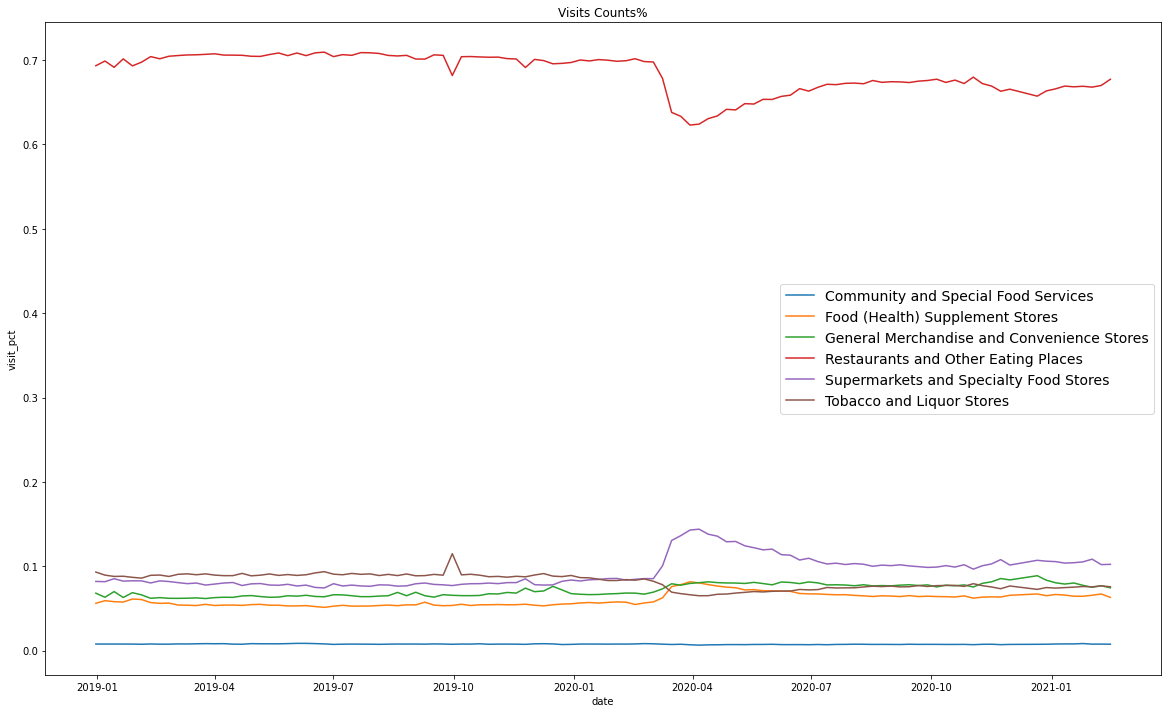

In [16]:
weekly_all_5 = weekly_all.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_all_5, x="date", y="visit_pct", hue="category")
plt.legend(fontsize='14')
plt.title("Visits Counts%")
plt.show()

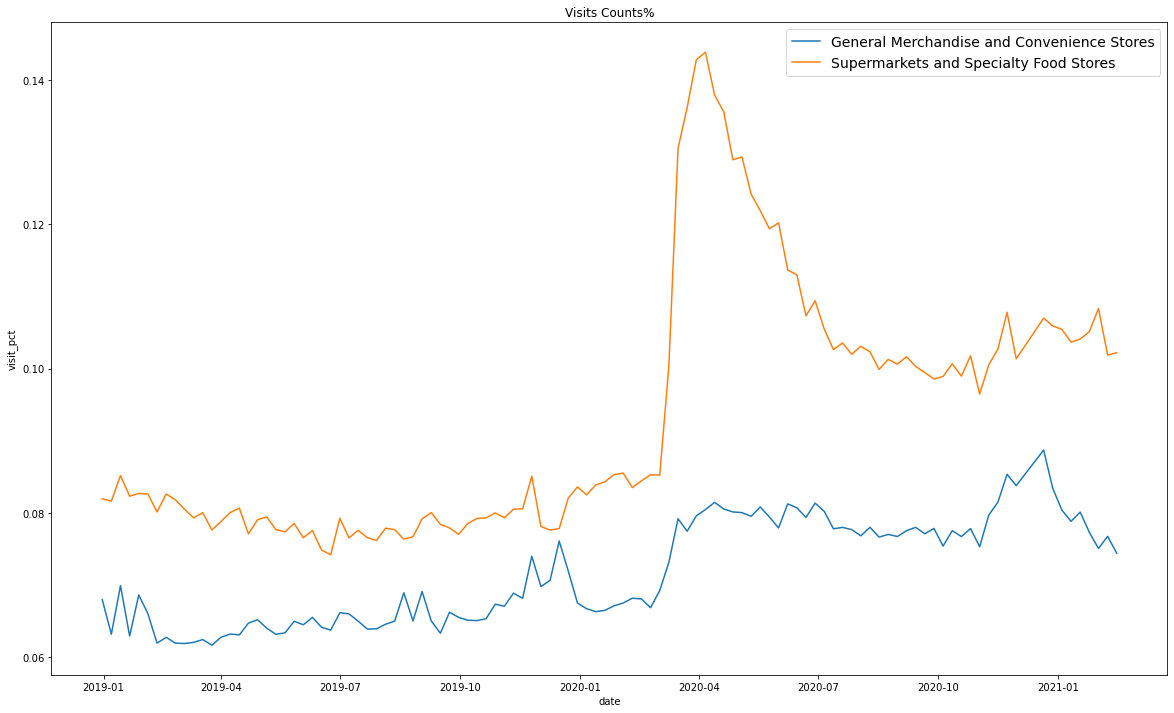

In [18]:

weekly_all_2=weekly_all[(weekly_all['category']=='General Merchandise and Convenience Stores')|(weekly_all['category']=='Supermarkets and Specialty Food Stores')]
weekly_all_2 = weekly_all_2.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 


plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_all_2, x="date", y="visit_pct", hue="category")
plt.legend(fontsize='14')
plt.title("Visits Counts%")
plt.show()

#### population

In [11]:
population = {'population':[4460101,4970026,912458,3123068,2717758],'borough':['Queens','Brooklyn','Staten Island','Manhattan','Bronx']}

population = pd.DataFrame(population)
population

,population,borough
0,4460101,Queens
1,4970026,Brooklyn
2,912458,Staten Island
3,3123068,Manhattan
4,2717758,Bronx


### Manhattan

In [12]:
weekly_Manhattan=weekly_sub[weekly_sub['borough']=='Manhattan']
weekly_Manhattan.head()

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,...,postal_code,top_category,sub_category,category,area_square_feet,date,density_visitors,density_visits,month,borough
880,224-222@627-s6f-6hq,2021-02-01 05:00:00+00:00,2,2,"[1,0,0,0,1,0,0]","[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610243012,{},"{""360610243012"":6}",NaN,...,10032,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Supermarkets and Specialty Food Stores,15398.0,2021-02-01,0.000130,0.000130,2,Manhattan
881,224-222@627-s6f-6hq,2021-02-15 05:00:00+00:00,2,2,"[0,1,0,1,0,0,0]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610243012,"{""360610235011"":4}",{},NaN,...,10032,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Supermarkets and Specialty Food Stores,15398.0,2021-02-15,0.000130,0.000130,2,Manhattan
882,224-222@627-s6f-6hq,2019-01-07 05:00:00+00:00,10,7,"[0,4,0,2,2,1,1]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610243012,"{""340270461061"":4,""090010739002"":4}",{},6796.0,...,10032,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Supermarkets and Specialty Food Stores,15398.0,2019-01-07,0.000455,0.000649,1,Manhattan
883,224-222@627-s6f-6hq,2019-02-04 05:00:00+00:00,2,2,"[0,0,0,0,0,1,1]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610243012,{},{},NaN,...,10032,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Supermarkets and Specialty Food Stores,15398.0,2019-02-04,0.000130,0.000130,2,Manhattan
884,224-222@627-s6f-6hq,2019-02-18 05:00:00+00:00,9,8,"[1,1,2,2,0,2,1]","[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0...",360610243012,"{""360610235014"":4,""340130147001"":4,""3606102450...","{""340030303004"":5,""360610295003"":4}",2782.0,...,10032,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,Supermarkets and Specialty Food Stores,15398.0,2019-02-18,0.000520,0.000584,2,Manhattan


In [13]:
weekly_Manhattan=pd.merge(weekly_Manhattan,weekly_totalboro,how='right',left_on='date',right_on='date')
weekly_Manhattan=weekly_Manhattan.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Manhattan.head(2)

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,...,sub_category,category,area_square_feet,date,density_visitors,density_visits,month,borough,totalvisit_sameday,totalvisitor_sameday
0,224-222@627-s6f-6hq,2018-12-31 05:00:00+00:00,10,5,"[0,0,0,2,2,4,2]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610243012,"{""360610241005"":4}",{},438.0,...,Supermarkets and Other Grocery (except Conveni...,Supermarkets and Specialty Food Stores,15398.0,2018-12-31,0.000325,0.000649,12,Manhattan,4590198,1913007
1,235-222@627-wc7-ygk,2018-12-31 05:00:00+00:00,8,4,"[0,2,4,2,0,0,0]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610016001,{},{},NaN,...,Retail Bakeries,Supermarkets and Specialty Food Stores,3435.0,2018-12-31,0.001164,0.002329,12,Manhattan,4590198,1913007


In [14]:
weekly_Manhattan['visit_pct']=weekly_Manhattan['raw_visit_counts']/weekly_Manhattan['totalvisit_sameday']
#weekly_Manhattan['10E5*visit/population']=weekly_Manhattan['raw_visit_counts']/3123068*100000


In [15]:
weekly_Manhattan.head()

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,...,category,area_square_feet,date,density_visitors,density_visits,month,borough,totalvisit_sameday,totalvisitor_sameday,visit_pct
0,224-222@627-s6f-6hq,2018-12-31 05:00:00+00:00,10,5,"[0,0,0,2,2,4,2]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610243012,"{""360610241005"":4}",{},438.0,...,Supermarkets and Specialty Food Stores,15398.0,2018-12-31,0.000325,0.000649,12,Manhattan,4590198,1913007,2.178555e-06
1,235-222@627-wc7-ygk,2018-12-31 05:00:00+00:00,8,4,"[0,2,4,2,0,0,0]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610016001,{},{},NaN,...,Supermarkets and Specialty Food Stores,3435.0,2018-12-31,0.001164,0.002329,12,Manhattan,4590198,1913007,1.742844e-06
2,224-225@627-s8r-6hq,2018-12-31 05:00:00+00:00,1,1,"[1,0,0,0,0,0,0]","[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610125001,{},{},NaN,...,Supermarkets and Specialty Food Stores,48478.0,2018-12-31,0.000021,0.000021,12,Manhattan,4590198,1913007,2.178555e-07
3,22d-222@627-s6d-6x5,2018-12-31 05:00:00+00:00,204,95,"[20,12,36,36,48,30,22]","[1,0,0,0,0,0,0,0,1,0,1,1,0,3,2,2,0,2,1,2,2,0,2...",360610245003,"{""360610247004"":12,""360610245002"":5,""360610247...","{""360610245001"":6,""360610245003"":5,""3606102150...",394.0,...,Supermarkets and Specialty Food Stores,10345.0,2018-12-31,0.009183,0.019720,12,Manhattan,4590198,1913007,4.444253e-05
4,233-222@627-s4n-2tv,2018-12-31 05:00:00+00:00,2,1,"[0,0,0,0,0,2,0]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",360610134008,{},{},NaN,...,Supermarkets and Specialty Food Stores,2160.0,2018-12-31,0.000463,0.000926,12,Manhattan,4590198,1913007,4.357111e-07


In [16]:
weekly_sub_Manhattan=weekly_Manhattan.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 


In [17]:
weekly_sub_Manhattan.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct
date,,,,,,,,
2018-12-31,1657958,695934,25605.712368,64.688483,92994922.0,0.009791,0.022950,0.361195
2019-01-07,1562742,728835,15519.259313,63.394905,94291612.0,0.010345,0.020319,0.370871
2019-01-14,1021335,749882,17206.017588,64.424857,93811543.0,0.010409,0.013516,0.368596
2019-01-21,961935,720572,15082.429482,63.593466,93805367.0,0.010339,0.013120,0.370449
2019-01-28,989070,728177,12116.677935,66.063181,94550622.0,0.010214,0.013100,0.363076


In [18]:
weekly_ctg_Manhattan = weekly_Manhattan.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 


In [19]:
weekly_ctg_Manhattan.head()

raw_visit_counts  \
category                            date                           
Community and Special Food Services 2018-12-31             15431   
                                    2019-01-07             15828   
                                    2019-01-14             10122   
                                    2019-01-21              9209   
                                    2019-01-28              9843   

                                                raw_visitor_counts  \
category                            date                             
Community and Special Food Services 2018-12-31                6214   
                                    2019-01-07                6949   
                                    2019-01-14                7009   
                                    2019-01-21                6556   
                                    2019-01-28                6945   

                                                distance_from_home  \
category                            date                             
Community and Special Food Services 2018-12-31        24494.854369   
                                    2019-01-07        25963.377358   
                                    2019-01-14        15037.443396   
                                    2019-01-21        13270.156863   
                                    2019-01-28        13755.673267   

                                                median_dwell  \
category                            date                       
Community and Special Food Services 2018-12-31     80.558559   
                                    2019-01-07     88.654867   
                                    2019-01-14     98.321429   
                                    2019-01-21     92.254464   
                                    2019-01-28     98.806306   

                                                area_square_feet  \
category                            date                           
Community and Special Food Services 2018-12-31          976388.0   
                                    2019-01-07          985781.0   
                                    2019-01-14          983616.0   
                                    2019-01-21          978553.0   
                                    2019-01-28          983616.0   

                                                density_visitors  \
category                            date                           
Community and Special Food Services 2018-12-31          0.007416   
                                    2019-01-07          0.007678   
                                    2019-01-14          0.007319   
                                    2019-01-21          0.007489   
                                    2019-01-28          0.008896   

                                                density_visits  visit_pct  
category                            date                                   
Community and Special Food Services 2018-12-31        0.016319   0.003362  
                                    2019-01-07        0.016390   0.003756  
                                    2019-01-14        0.009740   0.003653  
                                    2019-01-21        0.010910   0.003546  
                                    2019-01-28        0.011001   0.003613

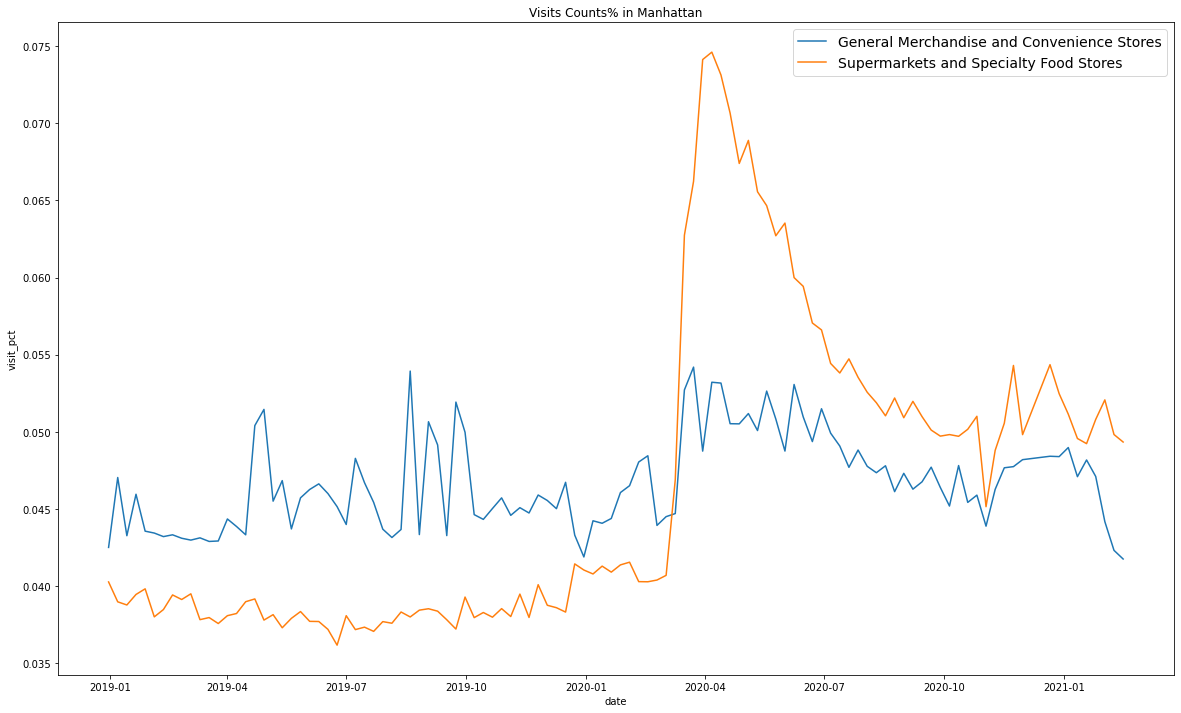

In [24]:
weekly_total_Manhattan= weekly_sub[weekly_sub.borough=='Manhattan'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_Manhattan=weekly_sub[weekly_sub['borough']=='Manhattan']
weekly_Manhattan=pd.merge(weekly_Manhattan,weekly_total_Manhattan,how='right',left_on='date',right_on='date')
weekly_Manhattan=weekly_Manhattan.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Manhattan['visit_pct']=weekly_Manhattan['raw_visit_counts']/weekly_Manhattan['totalvisit_sameday']

#
weekly_Manhattan=weekly_Manhattan[(weekly_Manhattan['category']=='General Merchandise and Convenience Stores')|(weekly_Manhattan['category']=='Supermarkets and Specialty Food Stores')]


weekly_ctg_Manhattan = weekly_Manhattan.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Manhattan, x="date", y="visit_pct", hue="category")
plt.legend(fontsize='14')
plt.title("Visits Counts% in Manhattan")
plt.show()

### Brooklyn

In [25]:
weekly_Brooklyn=weekly_sub[weekly_sub['borough']=='Brooklyn']
weekly_Brooklyn=pd.merge(weekly_Brooklyn,weekly_totalboro,how='right',left_on='date',right_on='date')
weekly_Brooklyn=weekly_Brooklyn.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Brooklyn['visit_pct']=weekly_Brooklyn['raw_visit_counts']/weekly_Brooklyn['totalvisit_sameday']
weekly_sub_Brooklyn=weekly_Brooklyn.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 

In [26]:
weekly_ctg_Brooklyn = weekly_Brooklyn.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 


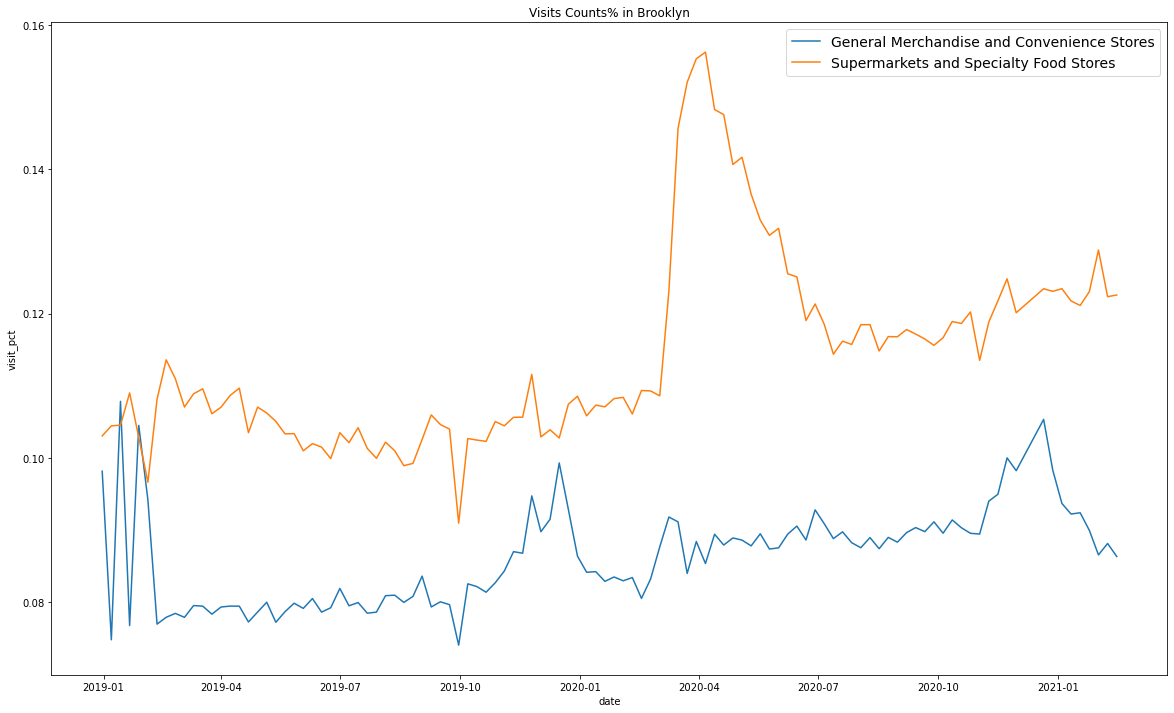

In [27]:
weekly_total_Brooklyn= weekly_sub[weekly_sub.borough=='Brooklyn'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_Brooklyn=weekly_sub[weekly_sub['borough']=='Brooklyn']
weekly_Brooklyn=pd.merge(weekly_Brooklyn,weekly_total_Brooklyn,how='right',left_on='date',right_on='date')
weekly_Brooklyn=weekly_Brooklyn.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Brooklyn['visit_pct']=weekly_Brooklyn['raw_visit_counts']/weekly_Brooklyn['totalvisit_sameday']

#
weekly_Brooklyn=weekly_Brooklyn[(weekly_Brooklyn['category']=='General Merchandise and Convenience Stores')|(weekly_Brooklyn['category']=='Supermarkets and Specialty Food Stores')]


weekly_ctg_Brooklyn = weekly_Brooklyn.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Brooklyn, x="date", y="visit_pct", hue="category")
plt.legend(fontsize='14')
plt.title("Visits Counts% in Brooklyn")
plt.show()

### Bronx

In [28]:
weekly_Bronx=weekly_sub[weekly_sub['borough']=='Bronx']
weekly_Bronx=pd.merge(weekly_Bronx,weekly_totalboro,how='right',left_on='date',right_on='date')
weekly_Bronx=weekly_Bronx.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Bronx['visit_pct']=weekly_Bronx['raw_visit_counts']/weekly_Bronx['totalvisit_sameday']
weekly_sub_Bronx=weekly_Bronx.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 

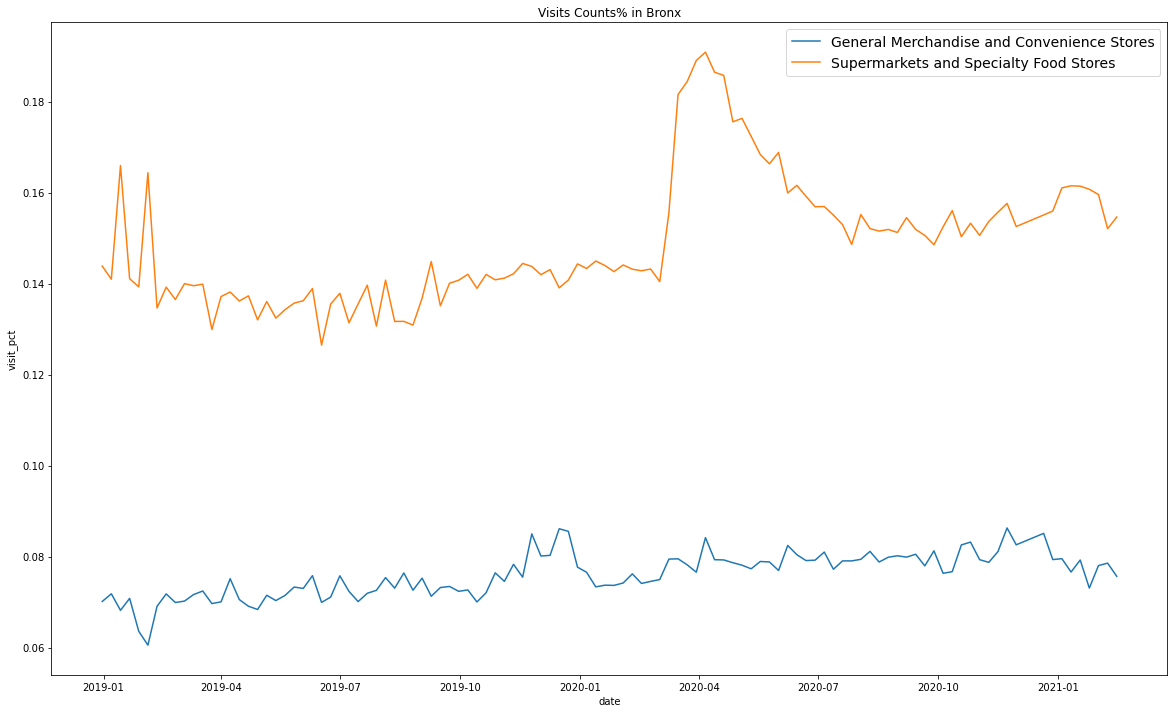

In [29]:
weekly_total_Bronx= weekly_sub[weekly_sub.borough=='Bronx'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_Bronx=weekly_sub[weekly_sub['borough']=='Bronx']
weekly_Bronx=pd.merge(weekly_Bronx,weekly_total_Bronx,how='right',left_on='date',right_on='date')
weekly_Bronx=weekly_Bronx.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Bronx['visit_pct']=weekly_Bronx['raw_visit_counts']/weekly_Bronx['totalvisit_sameday']

#
weekly_Bronx=weekly_Bronx[(weekly_Bronx['category']=='General Merchandise and Convenience Stores')|(weekly_Bronx['category']=='Supermarkets and Specialty Food Stores')]


weekly_ctg_Bronx = weekly_Bronx.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Bronx, x="date", y="visit_pct", hue="category")
plt.legend(fontsize='14')
plt.title("Visits Counts% in Bronx")
plt.show()

### Queens

In [30]:
weekly_Queens=weekly_sub[weekly_sub['borough']=='Queens']
weekly_Queens=pd.merge(weekly_Queens,weekly_totalboro,how='right',left_on='date',right_on='date')
weekly_Queens=weekly_Queens.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Queens['visit_pct']=weekly_Queens['raw_visit_counts']/weekly_Queens['totalvisit_sameday']
weekly_sub_Queens=weekly_Queens.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 

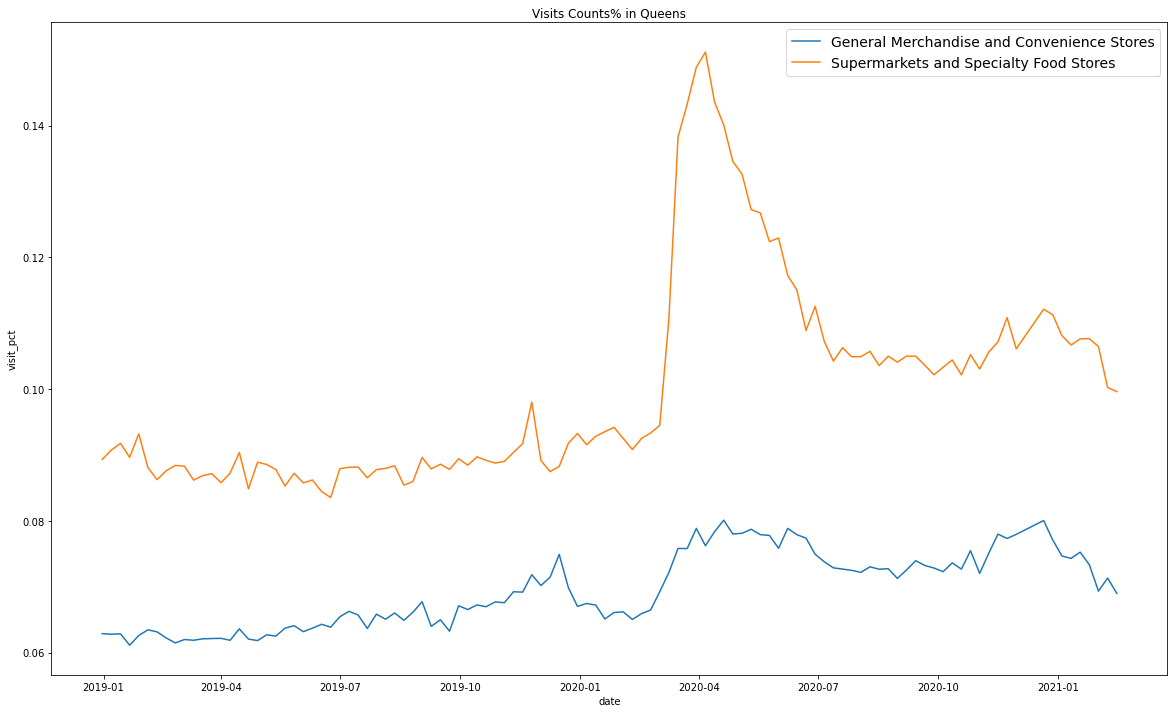

In [31]:
weekly_total_Queens= weekly_sub[weekly_sub.borough=='Queens'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_Queens=weekly_sub[weekly_sub['borough']=='Queens']
weekly_Queens=pd.merge(weekly_Queens,weekly_total_Queens,how='right',left_on='date',right_on='date')
weekly_Queens=weekly_Queens.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_Queens['visit_pct']=weekly_Queens['raw_visit_counts']/weekly_Queens['totalvisit_sameday']

#
weekly_Queens=weekly_Queens[(weekly_Queens['category']=='General Merchandise and Convenience Stores')|(weekly_Queens['category']=='Supermarkets and Specialty Food Stores')]



weekly_ctg_Queens = weekly_Queens.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_Queens, x="date", y="visit_pct", hue="category")
plt.legend(fontsize='14')
plt.title("Visits Counts% in Queens")
plt.show()

### Staten Island

In [32]:
weekly_StatenIsland=weekly_sub[weekly_sub['borough']=='Staten Island']
weekly_StatenIsland=pd.merge(weekly_StatenIsland,weekly_totalboro,how='right',left_on='date',right_on='date')
weekly_StatenIsland=weekly_StatenIsland.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_StatenIsland['visit_pct']=weekly_StatenIsland['raw_visit_counts']/weekly_StatenIsland['totalvisit_sameday']
weekly_sub_StatenIsland=weekly_StatenIsland.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 

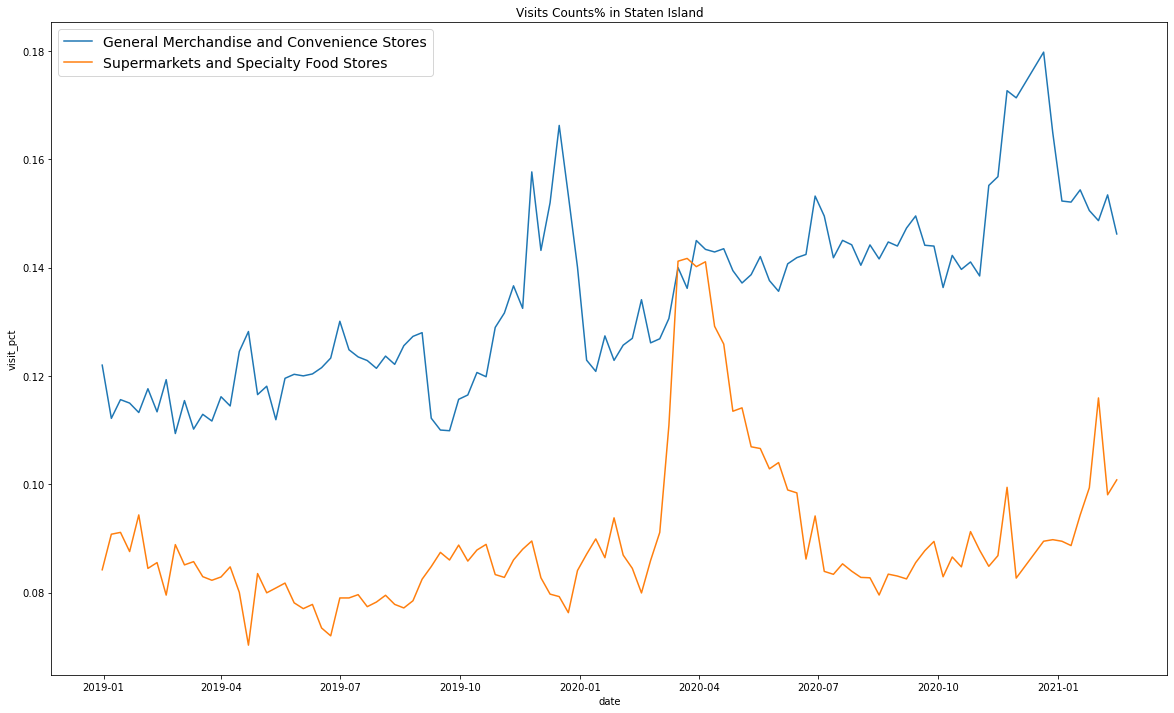

In [33]:
weekly_total_StatenIsland= weekly_sub[weekly_sub.borough=='Staten Island'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_StatenIsland=weekly_sub[weekly_sub['borough']=='Staten Island']
weekly_StatenIsland=pd.merge(weekly_StatenIsland,weekly_total_StatenIsland,how='right',left_on='date',right_on='date')
weekly_StatenIsland=weekly_StatenIsland.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_StatenIsland['visit_pct']=weekly_StatenIsland['raw_visit_counts']/weekly_StatenIsland['totalvisit_sameday']

#
weekly_StatenIsland=weekly_StatenIsland[(weekly_StatenIsland['category']=='General Merchandise and Convenience Stores')|(weekly_StatenIsland['category']=='Supermarkets and Specialty Food Stores')]

weekly_ctg_StatenIsland = weekly_StatenIsland.groupby(['category','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_ctg_StatenIsland, x="date", y="visit_pct", hue="category")
plt.legend(fontsize='14')
plt.title("Visits Counts% in Staten Island")
plt.show()

### Total

In [33]:
weekly_sub_Manhattan['borough']='Manhattan'
weekly_sub_Brooklyn['borough']='Brooklyn'
weekly_sub_Bronx['borough']='Bronx'
weekly_sub_Queens['borough']='Queens'
weekly_sub_StatenIsland['borough']='Staten Island'

In [68]:
weekly_sub_total_withpct = pd.concat([weekly_sub_Manhattan,weekly_sub_Brooklyn,weekly_sub_Bronx,weekly_sub_Queens,weekly_sub_StatenIsland])

In [35]:
weekly_sub_total_withpct

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct,borough
date,,,,,,,,,
2018-12-31,1657958,695934,25605.712368,64.688483,92994922.0,0.009791,0.022950,0.361195,Manhattan
2019-01-07,1562742,728835,15519.259313,63.394905,94291612.0,0.010345,0.020319,0.370871,Manhattan
2019-01-14,1021335,749882,17206.017588,64.424857,93811543.0,0.010409,0.013516,0.368596,Manhattan
2019-01-21,961935,720572,15082.429482,63.593466,93805367.0,0.010339,0.013120,0.370449,Manhattan
2019-01-28,989070,728177,12116.677935,66.063181,94550622.0,0.010214,0.013100,0.363076,Manhattan
...,...,...,...,...,...,...,...,...,...
2021-01-18,77437,60626,3676.807692,48.073391,10836720.0,0.009158,0.012273,0.073525,Staten Island
2021-01-25,75767,59202,3653.115865,44.003569,10627114.0,0.009082,0.011982,0.072913,Staten Island
2021-02-01,61597,49227,3554.304745,45.024092,10758879.0,0.007550,0.009537,0.068671,Staten Island


In [36]:
population

,population,borough
0,4460101,Queens
1,4970026,Brooklyn
2,912458,Staten Island
3,3123068,Manhattan
4,2717758,Bronx


In [69]:
weekly_sub_total_withpct['population']=0
weekly_sub_total_withpct['population'].iloc[weekly_sub_total_withpct['borough']=='Queens']=4460101
weekly_sub_total_withpct['population'].iloc[weekly_sub_total_withpct['borough']=='Brooklyn']=4970026
weekly_sub_total_withpct['population'].iloc[weekly_sub_total_withpct['borough']=='Staten Island']=912458
weekly_sub_total_withpct['population'].iloc[weekly_sub_total_withpct['borough']=='Manhattan']=3123068
weekly_sub_total_withpct['population'].iloc[weekly_sub_total_withpct['borough']=='Bronx']=2717758

In [38]:
weekly_sub_total_withpct.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct,borough,population
date,,,,,,,,,,
2018-12-31,1657958,695934,25605.712368,64.688483,92994922.0,0.009791,0.022950,0.361195,Manhattan,3123068
2019-01-07,1562742,728835,15519.259313,63.394905,94291612.0,0.010345,0.020319,0.370871,Manhattan,3123068
2019-01-14,1021335,749882,17206.017588,64.424857,93811543.0,0.010409,0.013516,0.368596,Manhattan,3123068
2019-01-21,961935,720572,15082.429482,63.593466,93805367.0,0.010339,0.013120,0.370449,Manhattan,3123068
2019-01-28,989070,728177,12116.677935,66.063181,94550622.0,0.010214,0.013100,0.363076,Manhattan,3123068


In [70]:
#weekly_sub_total_withpct=pd.merge(weekly_sub_total_withpct,population,how='outer',left_on='borough',right_on='borough')
weekly_sub_total_withpct['visit/boropopulation']=weekly_sub_total_withpct['raw_visit_counts']/weekly_sub_total_withpct['population']
weekly_sub_total_withpct.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct,borough,population,visit/boropopulation
date,,,,,,,,,,,
2018-12-31,1657958,695934,25605.712368,64.688483,92994922.0,0.009791,0.022950,0.361195,Manhattan,3123068,0.530875
2019-01-07,1562742,728835,15519.259313,63.394905,94291612.0,0.010345,0.020319,0.370871,Manhattan,3123068,0.500387
2019-01-14,1021335,749882,17206.017588,64.424857,93811543.0,0.010409,0.013516,0.368596,Manhattan,3123068,0.327029
2019-01-21,961935,720572,15082.429482,63.593466,93805367.0,0.010339,0.013120,0.370449,Manhattan,3123068,0.308010
2019-01-28,989070,728177,12116.677935,66.063181,94550622.0,0.010214,0.013100,0.363076,Manhattan,3123068,0.316698


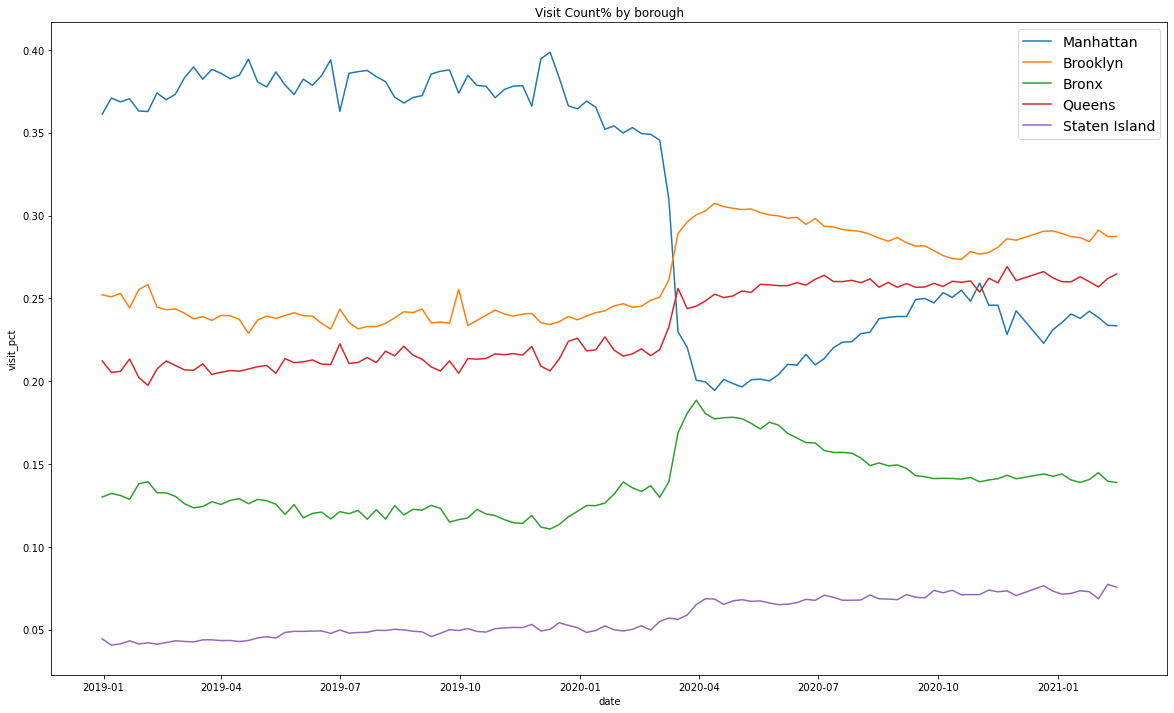

In [40]:
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_sub_total_withpct, x="date", y="visit_pct", hue="borough")
plt.legend(fontsize='14')
plt.title("Visit Count% by borough")
plt.show()

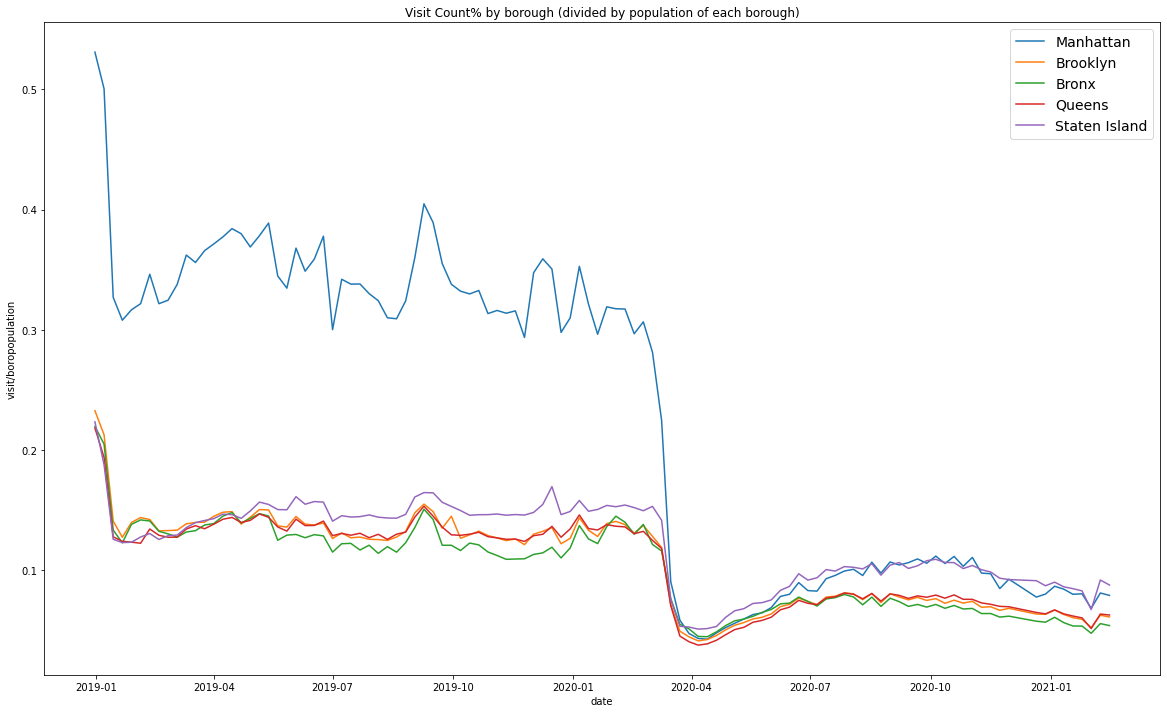

In [42]:
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_sub_total_withpct, x="date", y="visit/boropopulation", hue="borough")
plt.legend(fontsize='14')
plt.title("Visit Count% by borough (divided by population of each borough)")
plt.show() 

In [71]:
#选择 time period
weekly_sub_total_withpct.index=pd.to_datetime(weekly_sub_total_withpct.index)
weekly_sub_total_withpct['month']=weekly_sub_total_withpct.index.month
weekly_sub_total_withpct['week']=weekly_sub_total_withpct.index.week

In [44]:
weekly_sub_total_withpct.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct,borough,population,visit/boropopulation,month,week
date,,,,,,,,,,,,,
2018-12-31,1657958,695934,25605.712368,64.688483,92994922.0,0.009791,0.022950,0.361195,Manhattan,3123068,0.530875,12,1
2019-01-07,1562742,728835,15519.259313,63.394905,94291612.0,0.010345,0.020319,0.370871,Manhattan,3123068,0.500387,1,2
2019-01-14,1021335,749882,17206.017588,64.424857,93811543.0,0.010409,0.013516,0.368596,Manhattan,3123068,0.327029,1,3
2019-01-21,961935,720572,15082.429482,63.593466,93805367.0,0.010339,0.013120,0.370449,Manhattan,3123068,0.308010,1,4
2019-01-28,989070,728177,12116.677935,66.063181,94550622.0,0.010214,0.013100,0.363076,Manhattan,3123068,0.316698,1,5


In [45]:
period_mar_apr=weekly_sub_total_withpct[(weekly_sub_total_withpct.index>='2020-04-01')&(weekly_sub_total_withpct.index<='2020-04-30')]
period_mar_apr.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct,borough,population,visit/boropopulation,month,week
date,,,,,,,,,,,,,
2020-04-06,135822,100635,10535.591333,78.023358,79124686.0,0.001511,0.001856,0.199570,Manhattan,3123068,0.043490,4,15
2020-04-13,133912,97856,13934.973078,82.195077,78416897.0,0.001537,0.001902,0.194417,Manhattan,3123068,0.042878,4,16
2020-04-20,150253,110564,14985.982372,83.803922,81075836.0,0.001687,0.002102,0.201015,Manhattan,3123068,0.048111,4,17
2020-04-27,164000,121879,12972.613698,81.440112,81201931.0,0.001860,0.002252,0.198578,Manhattan,3123068,0.052512,4,18
2020-04-06,206111,161333,3726.392986,51.267272,36730033.0,0.004804,0.006008,0.302849,Brooklyn,4970026,0.041471,4,15


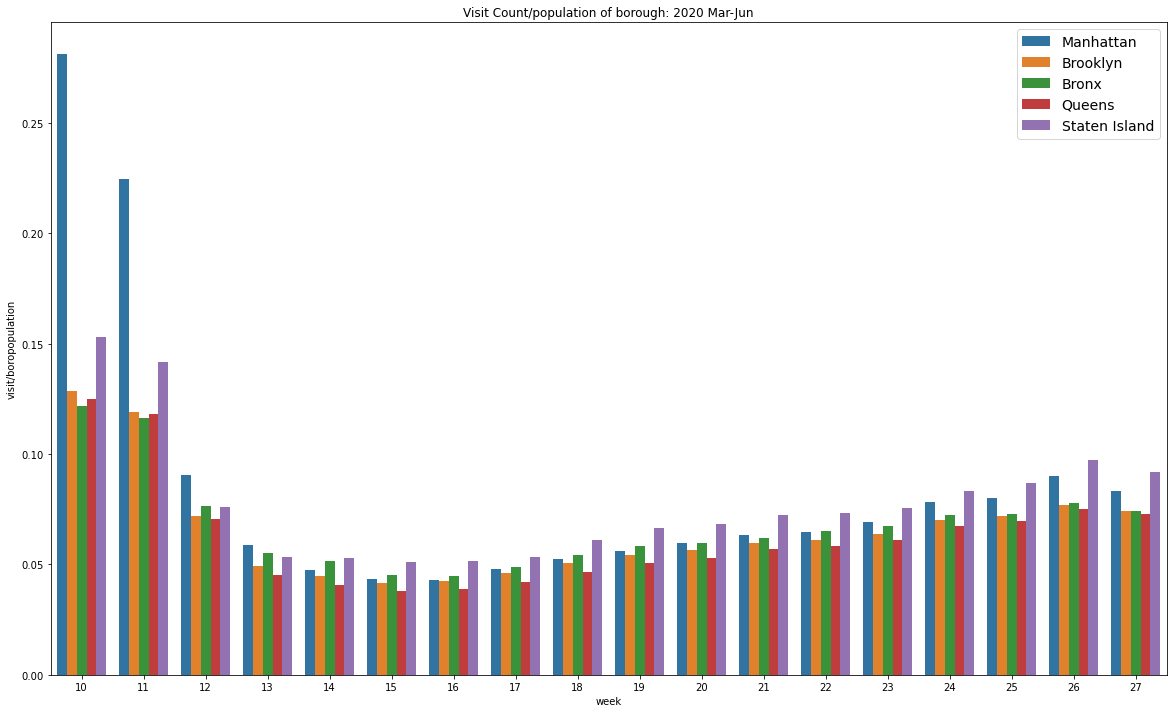

In [54]:
plt.figure(figsize=(20,12))
data=weekly_sub_total_withpct[(weekly_sub_total_withpct.index>='2020-03-01')&(weekly_sub_total_withpct.index<='2020-06-30')]
sns.barplot(data= data, x="week", y="visit/boropopulation", hue="borough",estimator=sum)
plt.legend(fontsize='14')
plt.title("Visit Count/population of borough: 2020 Mar-Jun")
plt.show()

In [47]:
weekly_sub_total_withpct.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct,borough,population,visit/boropopulation,month,week
date,,,,,,,,,,,,,
2018-12-31,1657958,695934,25605.712368,64.688483,92994922.0,0.009791,0.022950,0.361195,Manhattan,3123068,0.530875,12,1
2019-01-07,1562742,728835,15519.259313,63.394905,94291612.0,0.010345,0.020319,0.370871,Manhattan,3123068,0.500387,1,2
2019-01-14,1021335,749882,17206.017588,64.424857,93811543.0,0.010409,0.013516,0.368596,Manhattan,3123068,0.327029,1,3
2019-01-21,961935,720572,15082.429482,63.593466,93805367.0,0.010339,0.013120,0.370449,Manhattan,3123068,0.308010,1,4
2019-01-28,989070,728177,12116.677935,66.063181,94550622.0,0.010214,0.013100,0.363076,Manhattan,3123068,0.316698,1,5


In [72]:
weekly_sub_total_withpct['date']=weekly_sub_total_withpct.index
weekly_sub_total_withpct.reset_index(drop = True)

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,area_square_feet,density_visitors,density_visits,visit_pct,borough,population,visit/boropopulation,month,week,date
0,1657958,695934,25605.712368,64.688483,92994922.0,0.009791,0.022950,0.361195,Manhattan,3123068,0.530875,12,1,2018-12-31
1,1562742,728835,15519.259313,63.394905,94291612.0,0.010345,0.020319,0.370871,Manhattan,3123068,0.500387,1,2,2019-01-07
2,1021335,749882,17206.017588,64.424857,93811543.0,0.010409,0.013516,0.368596,Manhattan,3123068,0.327029,1,3,2019-01-14
3,961935,720572,15082.429482,63.593466,93805367.0,0.010339,0.013120,0.370449,Manhattan,3123068,0.308010,1,4,2019-01-21
4,989070,728177,12116.677935,66.063181,94550622.0,0.010214,0.013100,0.363076,Manhattan,3123068,0.316698,1,5,2019-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,77437,60626,3676.807692,48.073391,10836720.0,0.009158,0.012273,0.073525,Staten Island,912458,0.084866,1,3,2021-01-18
546,75767,59202,3653.115865,44.003569,10627114.0,0.009082,0.011982,0.072913,Staten Island,912458,0.083036,1,4,2021-01-25
547,61597,49227,3554.304745,45.024092,10758879.0,0.007550,0.009537,0.068671,Staten Island,912458,0.067507,2,5,2021-02-01
548,83988,66332,3720.407537,38.269231,10994667.0,0.010101,0.013286,0.077351,Staten Island,912458,0.092046,2,6,2021-02-08


In [65]:
weekly_sub_total_withpct.index[:1]

DatetimeIndex(['2018-12-31'], dtype='datetime64[ns]', name='date', freq=None)

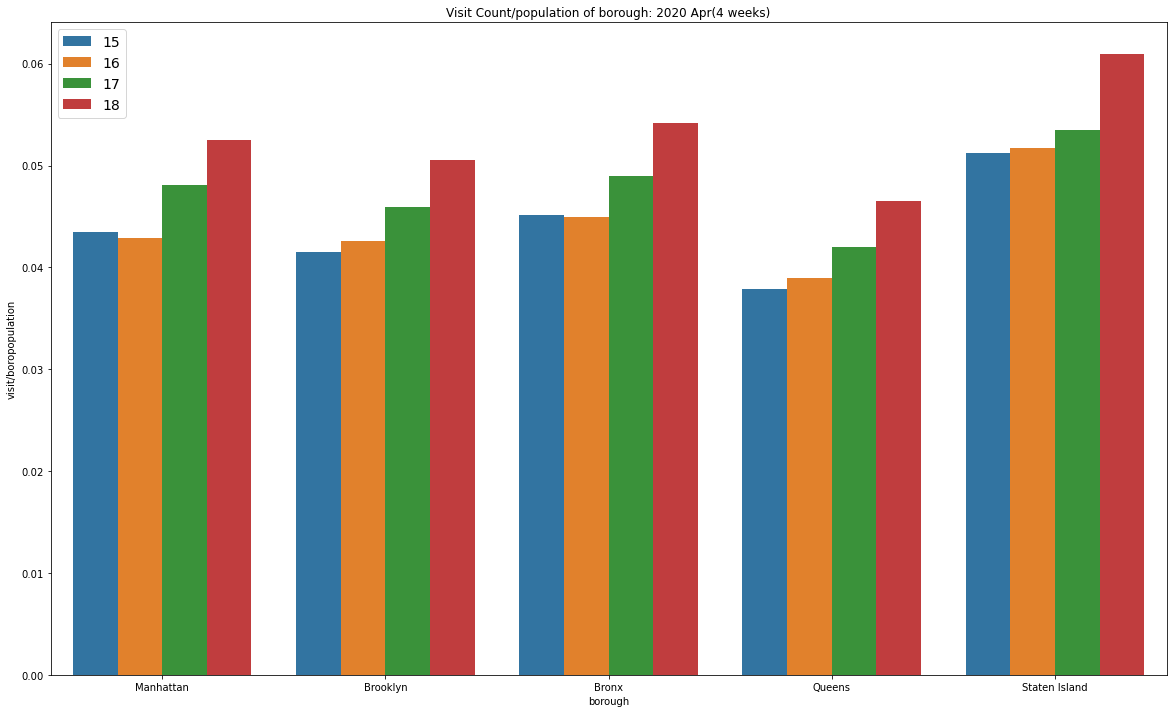

In [69]:
plt.figure(figsize=(20,12))
sns.barplot(data= period_mar_apr, x="borough", y="visit/boropopulation", hue="week")
plt.legend(fontsize='14')
plt.title("Visit Count/population of borough: 2020 Apr(4 weeks)")
plt.show()

### Community and Special Food Services


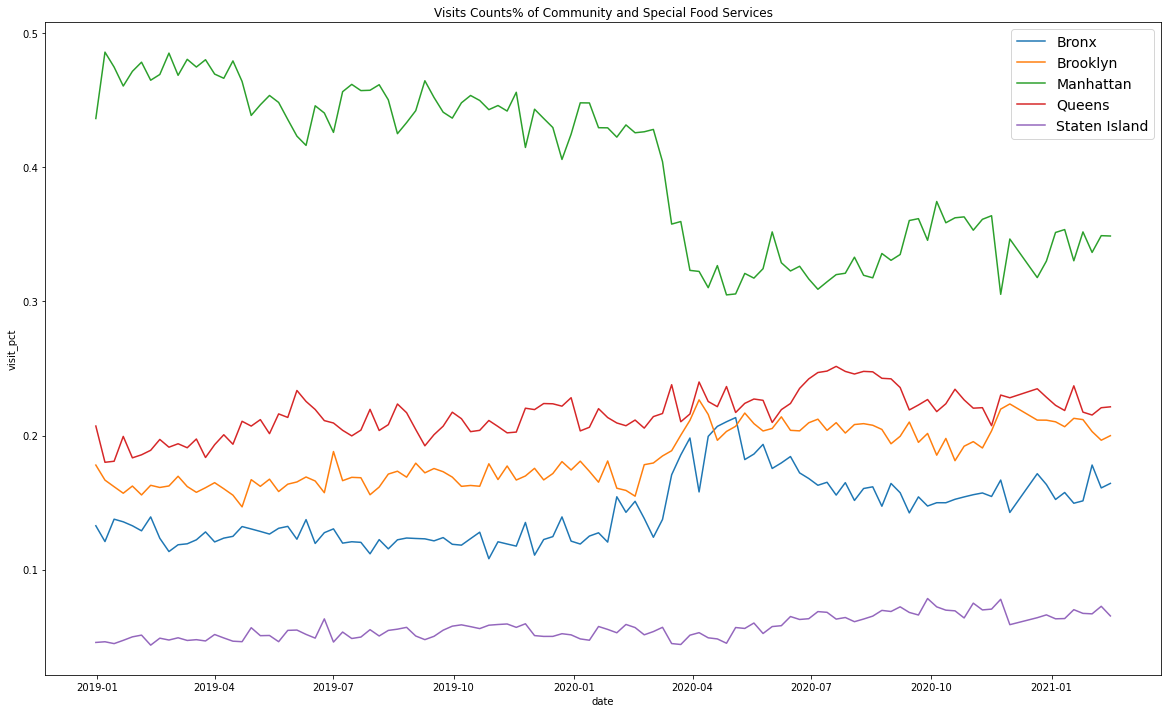

In [40]:
weekly_total_community= weekly_sub[weekly_sub.category=='Community and Special Food Services'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_community=weekly_sub[weekly_sub['category']=='Community and Special Food Services']
weekly_community=pd.merge(weekly_community,weekly_total_community,how='right',left_on='date',right_on='date')
weekly_community=weekly_community.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_community['visit_pct']=weekly_community['raw_visit_counts']/weekly_community['totalvisit_sameday']
weekly_boro_community = weekly_community.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_community, x="date", y="visit_pct", hue="borough")
plt.legend(fontsize='14')
plt.title("Visits Counts% of Community and Special Food Services")
plt.show()

In [41]:
weekly_boro_community.head()

raw_visit_counts  raw_visitor_counts  distance_from_home  \
borough date                                                                   
Bronx   2018-12-31              4694                1775             4037.40   
        2019-01-07              3941                1793             4160.75   
        2019-01-14              2935                1906             4044.10   
        2019-01-21              2713                1784             4116.40   
        2019-01-28              2771                1843             3372.95   

                    median_dwell  area_square_feet  density_visitors  \
borough date                                                           
Bronx   2018-12-31      94.97619          483871.0          0.021135   
        2019-01-07      45.05000          483871.0          0.019829   
        2019-01-14      51.40000          483871.0          0.019710   
        2019-01-21      60.07500          483871.0          0.019829   
        2019-01-28      49.12500          483871.0          0.023035   

                    density_visits  visit_pct  
borough date                                   
Bronx   2018-12-31        0.053788   0.132749  
        2019-01-07        0.043101   0.120982  
        2019-01-14        0.030397   0.137658  
        2019-01-21        0.029803   0.135697  
        2019-01-28        0.034671   0.132755

### Supermarkets and Specialty Food Stores

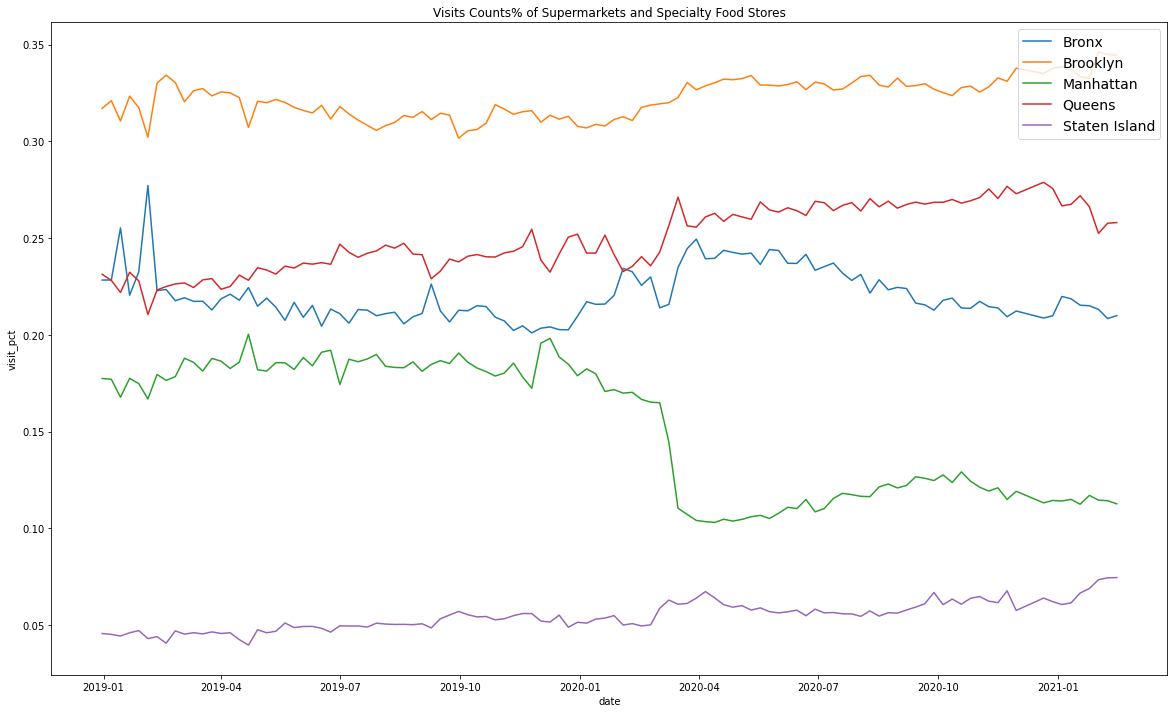

In [42]:
weekly_total_supermarket= weekly_sub[weekly_sub.category=='Supermarkets and Specialty Food Stores'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_supermarket=weekly_sub[weekly_sub['category']=='Supermarkets and Specialty Food Stores']
weekly_supermarket=pd.merge(weekly_supermarket,weekly_total_supermarket,how='right',left_on='date',right_on='date')
weekly_supermarket=weekly_supermarket.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_supermarket['visit_pct']=weekly_supermarket['raw_visit_counts']/weekly_supermarket['totalvisit_sameday']
weekly_boro_supermarket = weekly_supermarket.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_supermarket, x="date", y="visit_pct", hue="borough")
plt.legend(fontsize='14')
plt.title("Visits Counts% of Supermarkets and Specialty Food Stores")
plt.show()

### Restaurants and Other Eating Places

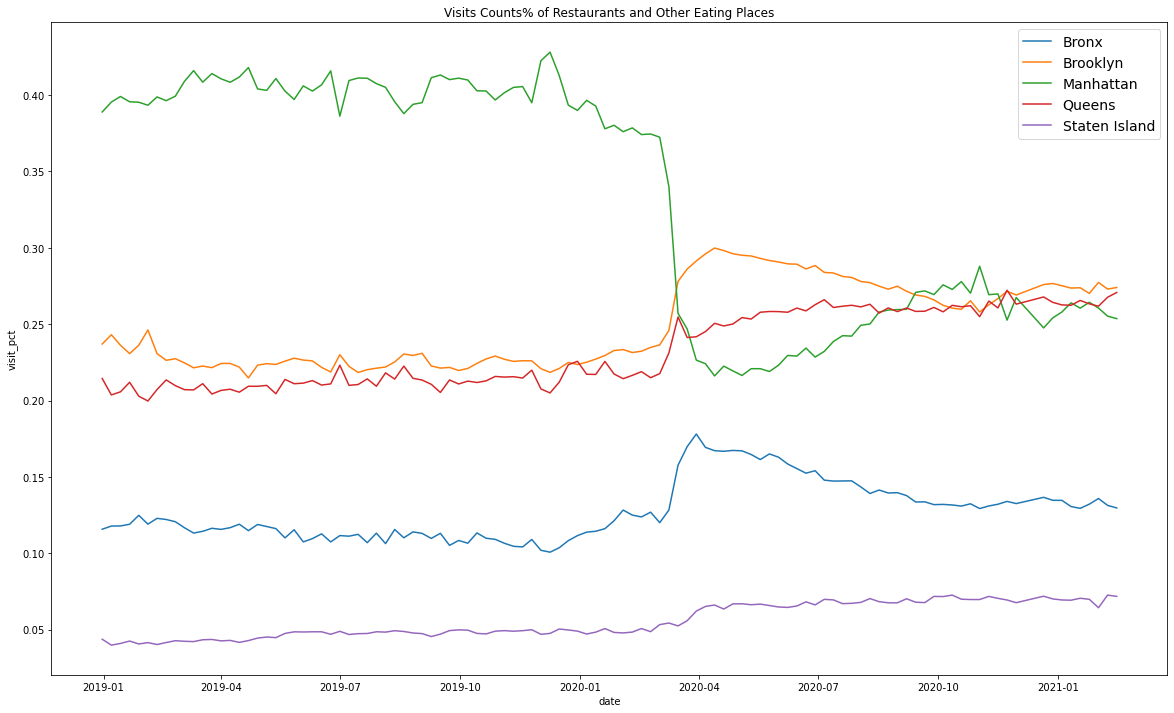

In [43]:
weekly_total_restaurant= weekly_sub[weekly_sub.category=='Restaurants and Other Eating Places'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_restaurant=weekly_sub[weekly_sub['category']=='Restaurants and Other Eating Places']
weekly_restaurant=pd.merge(weekly_restaurant,weekly_total_restaurant,how='right',left_on='date',right_on='date')
weekly_restaurant=weekly_restaurant.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_restaurant['visit_pct']=weekly_restaurant['raw_visit_counts']/weekly_restaurant['totalvisit_sameday']
weekly_boro_restaurant = weekly_restaurant.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_restaurant, x="date", y="visit_pct", hue="borough")
plt.legend(fontsize='14')
plt.title("Visits Counts% of Restaurants and Other Eating Places")
plt.show()

### General Merchandise and Convenience Stores

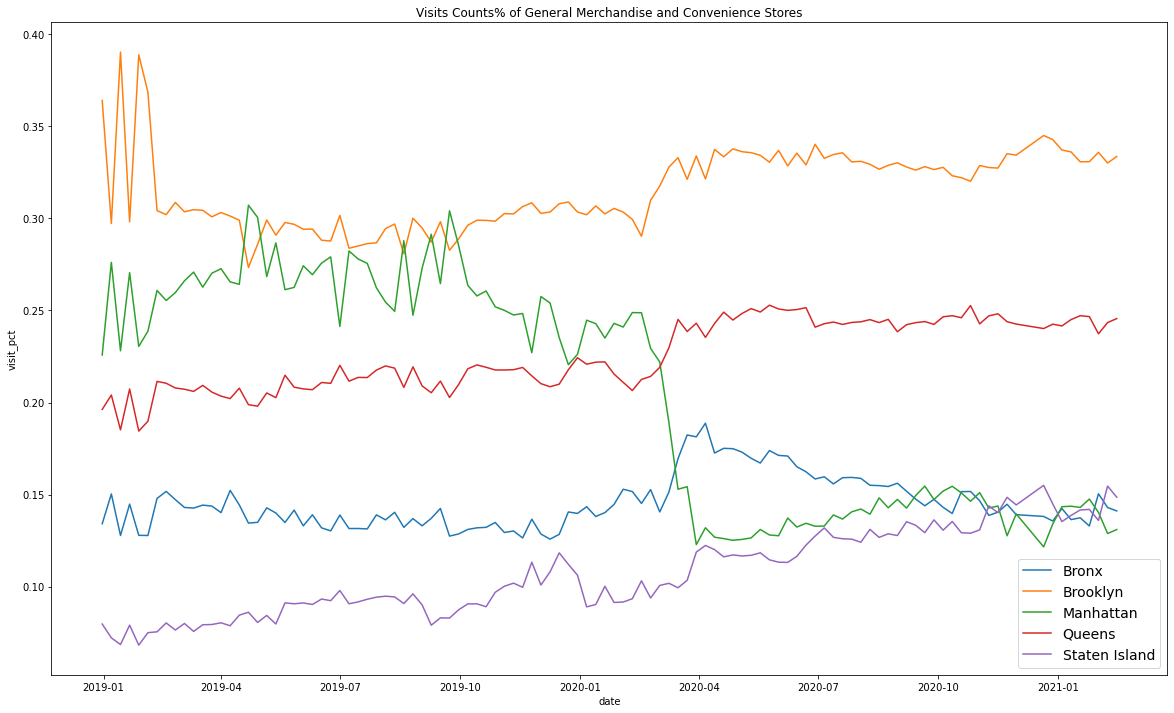

In [44]:
weekly_total_general= weekly_sub[weekly_sub.category=='General Merchandise and Convenience Stores'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_general=weekly_sub[weekly_sub['category']=='General Merchandise and Convenience Stores']
weekly_general=pd.merge(weekly_general,weekly_total_general,how='right',left_on='date',right_on='date')
weekly_general=weekly_general.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_general['visit_pct']=weekly_general['raw_visit_counts']/weekly_general['totalvisit_sameday']
weekly_boro_general = weekly_general.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_general, x="date", y="visit_pct", hue="borough")
plt.legend(fontsize='14')
plt.title("Visits Counts% of General Merchandise and Convenience Stores")
plt.show()

### Food (Health) Supplement Stores

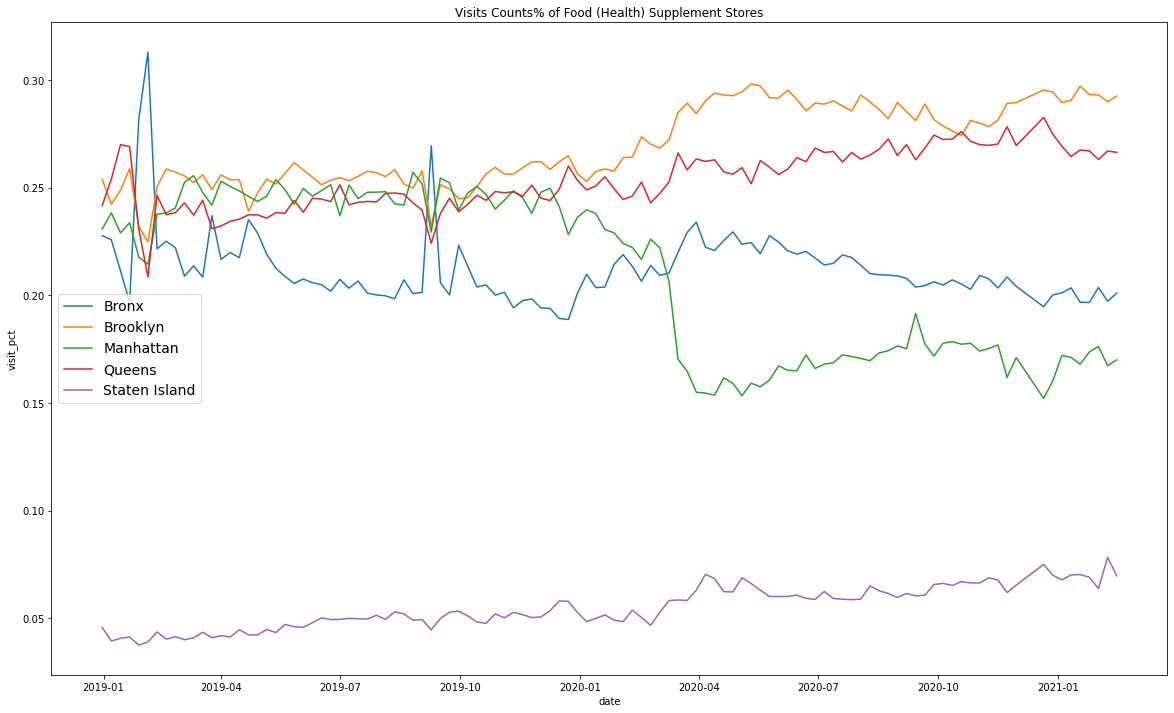

In [45]:
weekly_total_food= weekly_sub[weekly_sub.category=='Food (Health) Supplement Stores'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_food=weekly_sub[weekly_sub['category']=='Food (Health) Supplement Stores']
weekly_food=pd.merge(weekly_food,weekly_total_food,how='right',left_on='date',right_on='date')
weekly_food=weekly_food.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_food['visit_pct']=weekly_food['raw_visit_counts']/weekly_food['totalvisit_sameday']
weekly_boro_food = weekly_food.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_food, x="date", y="visit_pct", hue="borough")
plt.legend(fontsize='14')
plt.title("Visits Counts% of Food (Health) Supplement Stores")
plt.show()

### Tobacco and Liquor Stores

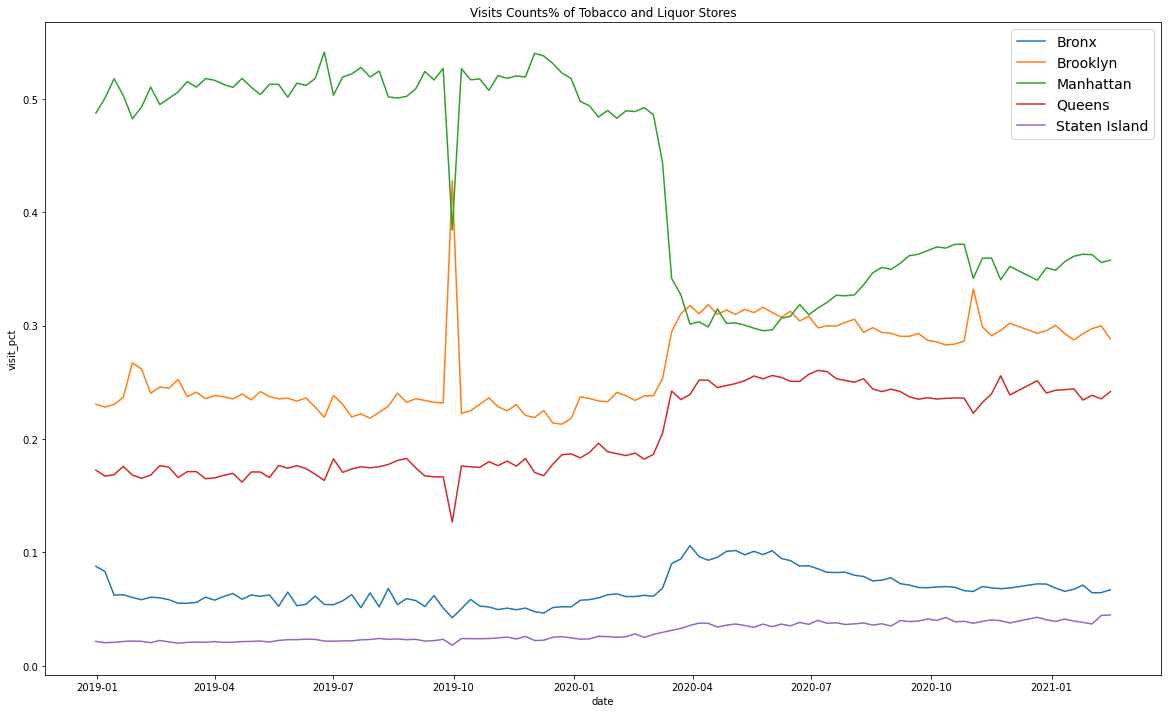

In [46]:
weekly_total_tobacco= weekly_sub[weekly_sub.category=='Tobacco and Liquor Stores'].groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum'}) 
weekly_tobacco=weekly_sub[weekly_sub['category']=='Tobacco and Liquor Stores']
weekly_tobacco=pd.merge(weekly_tobacco,weekly_total_tobacco,how='right',left_on='date',right_on='date')
weekly_tobacco=weekly_tobacco.rename(columns={'raw_visit_counts_x':'raw_visit_counts','raw_visitor_counts_x':'raw_visitor_counts','raw_visit_counts_y':'totalvisit_sameday','raw_visitor_counts_y':'totalvisitor_sameday'})
weekly_tobacco['visit_pct']=weekly_tobacco['raw_visit_counts']/weekly_tobacco['totalvisit_sameday']
weekly_boro_tobacco = weekly_tobacco.groupby(['borough','date']).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean',
                                          'area_square_feet':'sum','density_visitors':'median','density_visits':'median','visit_pct':'sum'}) 
plt.figure(figsize=(20,12))
sns.lineplot(data= weekly_boro_tobacco, x="date", y="visit_pct", hue="borough")
plt.legend(fontsize='14')
plt.title("Visits Counts% of Tobacco and Liquor Stores")
plt.show()